<a href="https://colab.research.google.com/github/Sadegh-Abbasi/Distribution-System-Network-Planning/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:

This project involves planning and costing a section of the distribution network in Tampere city using futuristic load and DG data. The goal is to sensibly plan the network feeding from two primary substations. The network includes two primary and 16 secondary substations in the region between them. Each substation has a mix of consumption and generation based on measured data from renewable DG-rich Germany and an anticipated increase in demand due to electric vehicle charging and general electrification. The load growth is expected to nearly double over the next 20 years. The topology consists of two radial spurs fed from one primary station to ensure a simple topology that can handle single faults. During normal operation, the switches of the back-up cable in the middle are open.

Topology:

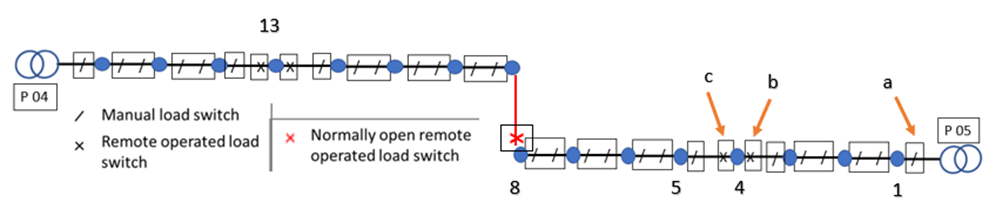

Here is the simulation of power flow and short circuit calculations with Pandapower for validating calculations and visualizing on map.

Note: For running the simulation, a Mapbox token should be added.

#Install & Import necessary modules & Initialization

In [233]:
%%capture
!pip install pandapower
!pip install pyproj
!pip install --upgrade plotly

In [234]:
import pandapower as pp
import pandas as pd
import pandapower.shortcircuit as sc
from pandapower.plotting.plotly.mapbox_plot import set_mapbox_token
# please add your mapbox token
set_mapbox_token("<Token>")
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting.plotly import pf_res_plotly

Adress of the excel data file and creating an empty network

In [235]:
# please write the address of excel input file the name of it in the sent fiels is Project V.2 
fadress='/Project V.2.xlsx' 


net = pp.create_empty_network(f_hz=50.0,sn_mva=1)
nb=0

#Functions

The network shall be designed and operate under (for more information see the report.pdf): 



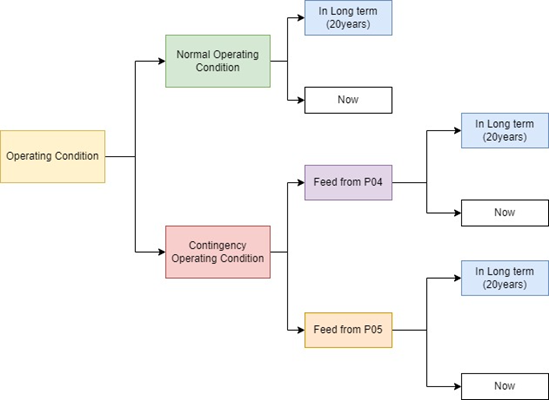

All of the charactristics such as connections, line parameters(resistance, reactance, etc), bus parameters (voltage, location,...) and etc  are defined in the excel file. 

##Busses
Defining Buses:
function accepts "True" for defining all of the primary and "false" for only our primary substations.

In [236]:
def Buses(all):
    #Defining Buses
    df= pd.read_excel(fadress, sheet_name="Bus", index_col=0)
    for idx in df.index:
        pp.create_bus(net,vn_kv=df.at[idx,"Voltage"],name=df.at[idx,"Bus name"],geodata=(df.at[idx,"location Y"], df.at[idx,"location X"]))
        global nb
        nb=len(df)
    
    #Defining All the Primary Busses
    if all==True:
        df= pd.read_excel(fadress, sheet_name="Primary Buses", index_col=0)
        for idx in df.index:
            pp.create_bus(net,vn_kv=df.at[idx,"Voltage"],name=df.at[idx,"Bus name"],geodata=(df.at[idx,"location Y"], df.at[idx,"location X"]))
            b=int(nb+idx-1)
            pp.create_ext_grid(net, bus=net.bus.index[b], name="infinite", vm_pu=1.00, va_degree=0.0)
    return(nb)  

##Loads
Defining Loads:
Loads accept state for now or 20 years.

In [237]:
def Loads(state):
    #Defining Loads  Now or 20 Years
    df=pd.read_excel(fadress, sheet_name="Load", index_col=0)
    if state=="Now":
        for idx in df.index:
            pp.create_load(net,name=df.at[idx,"Name"],bus=df.at[idx,"Bus"],p_mw=df.at[idx,"Pmax"],q_mvar=df.at[idx,"Qmax"],max_p_mw=df.at[idx,"Pmax"],min_p_mw=df.at[idx,"Pmin"],max_q_mvar=df.at[idx,"Qmax"],min_q_mvar=df.at[idx,"Qmin"])
    # withh p=pmax and q=qmax  pp.create_load(net,name=df.at[idx,"Name"],bus=df.at[idx,"Bus"],p_mw=df.at[idx,"Pmax"],q_mvar=df.at[idx,"Qmax"],max_p_mw=df.at[idx,"Pmax"],min_p_mw=df.at[idx,"Pmin"],max_q_mvar=df.at[idx,"Qmax"],min_q_mvar=df.at[idx,"Qmin"])
    elif state=="20years":
        for idx in df.index:
            pp.create_load(net,name=df.at[idx,"Name"],bus=df.at[idx,"Bus"],p_mw=df.at[idx,"Pmax20"],q_mvar=df.at[idx,"Qmax20"],max_p_mw=df.at[idx,"Pmax20"],min_p_mw=df.at[idx,"Pmin20"],max_q_mvar=df.at[idx,"Qmax20"],min_q_mvar=df.at[idx,"Qmin20"])
    return


##Lines
Defining Lines:

In [238]:
def Line():
#Defining Lines
    df=pd.read_excel(fadress, sheet_name="Line", index_col=0)
    for idx in df.index:
        pp.create_line_from_parameters(net,name=df.at[idx,"name"],from_bus=df.at[idx,"from_bus"],to_bus=df.at[idx,"to_bus"],length_km=df.at[idx,"length_km"],r_ohm_per_km=df.at[idx,"r_ohm_per_km"],x_ohm_per_km=df.at[idx,"x_ohm_per_km"],c_nf_per_km=df.at[idx,"c_nf_per_km"],r0_ohm_per_km=df.at[idx,"r0_ohm_per_km"],x0_ohm_per_km=df.at[idx,"x0_ohm_per_km"],c0_nf_per_km=df.at[idx,"c0_nf_per_km"],max_i_ka=df.at[idx,"max_i_ka"])
    return


## Transformers and External Grids
Defining Transformers and External Grids:
Two transformers are working in parallel in each primary station an considered as pure inductive.

In [239]:
def rest():
    #Defining External Grids
    #for power folw
    """  pp.create_ext_grid(net, bus=net.bus.index[1], name="P05", vm_pu=1.00, va_degree=0.0,s_sc_max_mva=2400,rx_max=0)
    pp.create_ext_grid(net, bus=net.bus.index[0], name="P04", vm_pu=1.00, va_degree=0.0,s_sc_max_mva=2400,rx_max=0) """
    #for general case 
    pp.create_ext_grid(net, bus=net.bus.index[nb-1], name="P05", vm_pu=1.00, va_degree=0.0,s_sc_max_mva=2400,rx_max=0)
    pp.create_ext_grid(net, bus=net.bus.index[nb-2], name="P04", vm_pu=1.00, va_degree=0.0,s_sc_max_mva=2400,rx_max=0)
    #Defining Transformers
    pp.create_transformer(net, net.bus.index[nb-1], net.bus.index[1] , std_type="40 MVA 110/20 kV",parallel=2)
    pp.create_transformer(net, net.bus.index[nb-2], net.bus.index[0] , std_type="40 MVA 110/20 kV",parallel=2)
    net.trafo.vk_percent[0]=10
    net.trafo.vk_percent[1]=10
    net.trafo.vkr_percent[0]=0.0
    net.trafo.vkr_percent[1]=0.0
    net.trafo.tap_pos[0]=0
    net.trafo.tap_pos[1]=0
    #print(net.trafo)
    return

## Operation Topology


###Defining Operation Topology:
Operation can be 'Normal', 'Contingency_P04' and 'Contingency_P05' and topology is modified by changing state of switches. 

In [240]:
def Operation_Topology (state):
    if state=='Normal':
        swo = pp.create_switch(net, bus=net.bus.index[9], element=net.line.index[8], et="l", type="LBS", closed=False)
        #print(state)
        return()
    elif state== 'Contingency_P04':
        sw4 = pp.create_switch(net, bus=net.bus.index[0], element=net.line.index[16], et="l", type="LBS", closed=False)
        #print(state)
        return()
    elif state== 'Contingency_P05':
        sw4 = pp.create_switch(net, bus=net.bus.index[1], element=net.line.index[0], et="l", type="LBS", closed=False)
        #print(state)
        return()

### Operation Topology presenation on map:

In [241]:
def Operation_Topology_presentation (style):
    simple_plotly(net, on_map=True, map_style=style, projection="epsg:3035")

##Short Circuit:


###Short Circuit calculation:

In [242]:
def SC_calculation():
    sc.calc_sc(net, case="max",branch_results=True)
    net.res_bus_sc
    net.res_line_sc

### Short Circuit Presentation:

In [243]:

def SC_calculation_presentation(line,bus):
    if line==True:
        print(net.res_line_sc)
    if bus==True:
        print(net.res_bus_sc)
    return

##Power Flow:


###Power Flow Calculation:

In [249]:
def Powerflow_calculation():
    pp.runpp(net,"nr")

###Power Flow Presentation:

In [250]:
def Powerflow_presentation(table,map):
    if table==True:
        print(net.res_line)
    if map==True:
        pf_res_plotly(net,on_map=True,map_style="streets", projection="epsg:3035")
    return

#Run & Results

In [246]:
Buses(all=False)
Loads(state="Now") 
#Loads(state="20years")
Line()
rest()
Operation_Topology(state="Normal")
#Operation_Topology(state='Contingency_P04')
#Operation_Topology(state='Contingency_P05')

()

Operation Topology can be seen on Map


In [216]:
# Operation_Topology_presentation(style='streets')
# style can be streets, dark, satellite

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/usr/local/lib/python3.9/dist-packages/pandapower/plotting/plotly/mapbox_plot.py:86: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



Example result for Normal with street style:


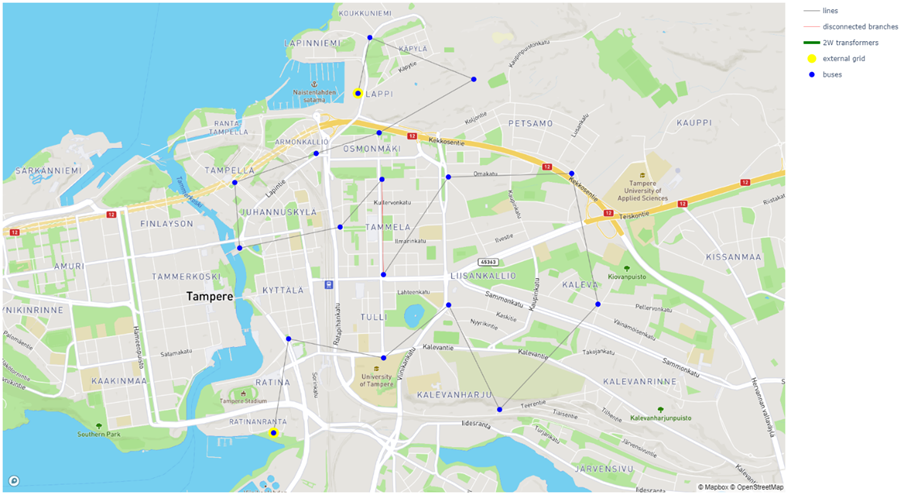

In [247]:
Powerflow_calculation()
Powerflow_presentation(table=True,map=False)

    p_from_mw  q_from_mvar       p_to_mw  q_to_mvar         pl_mw   ql_mvar  \
0    5.656985     0.707559 -5.654713e+00  -0.719885  2.271901e-03 -0.012326   
1    4.807713     0.612885 -4.803740e+00  -0.643741  3.973773e-03 -0.030856   
2    3.982740     0.432741 -3.980035e+00  -0.464285  2.704891e-03 -0.031544   
3    3.265035     0.431285 -3.264136e+00  -0.447073  8.987129e-04 -0.015788   
4    2.341136     0.365073 -2.340477e+00  -0.387841  6.590005e-04 -0.022768   
5    1.599477     0.275841 -1.599242e+00  -0.293333  2.352599e-04 -0.017492   
6    1.111242     0.207333 -1.111054e+00  -0.236077  1.872592e-04 -0.028744   
7    0.748054     0.083077 -7.480000e-01  -0.102000  5.443531e-05 -0.018923   
8    0.000000     0.000000  1.126722e-08  -0.020699  1.126722e-08 -0.020699   
9   -0.862000    -0.050301  8.621344e-01   0.014850  1.343981e-04 -0.035450   
10  -1.780134    -0.188850  1.780666e+00   0.156510  5.314866e-04 -0.032340   
11  -2.562666    -0.167510  2.563890e+00   0.131767 

Example result of power flow calculation under Normal operating condition and  street style of map:

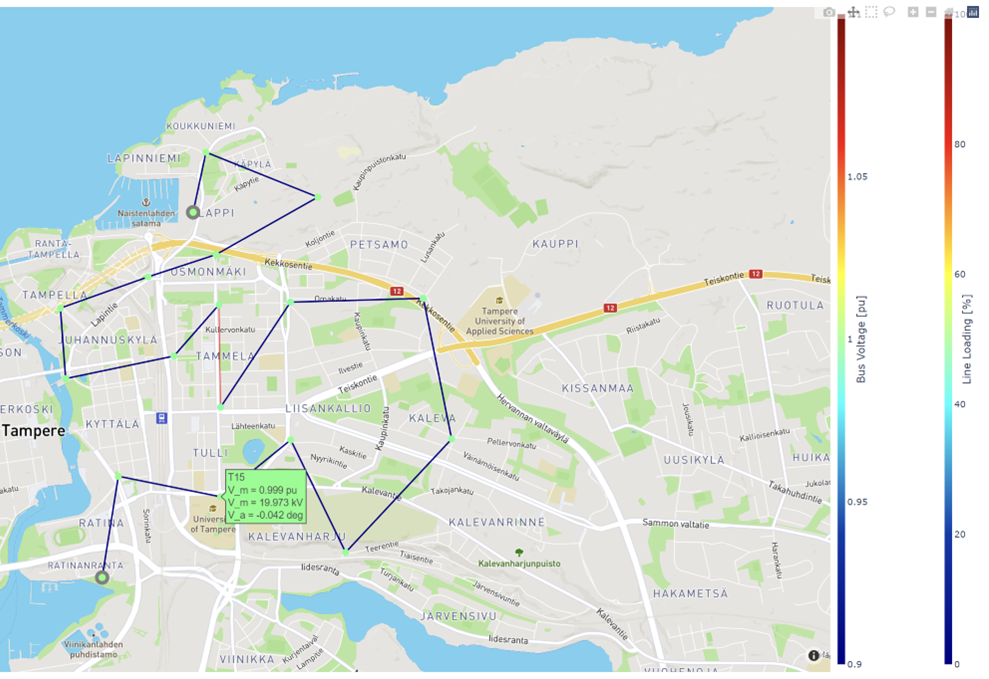

In [248]:
SC_calculation()
SC_calculation_presentation(line=True,bus=False)

      ikss_ka
0   18.216174
1   16.885463
2   15.647527
3   15.077485
4   14.315996
5   13.772358
6   12.946618
7   12.445118
8    0.000000
9   10.903634
10  11.681064
11  12.481631
12  13.485620
13  14.687072
14  16.147830
15  16.839504
16  17.806588


/usr/local/lib/python3.9/dist-packages/pandapower/shortcircuit/currents.py:265: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.9/dist-packages/pandapower/shortcircuit/currents.py:266: RuntimeWarning:

All-NaN slice encountered



Simulation results are  compared with calculated results in the following tables. 

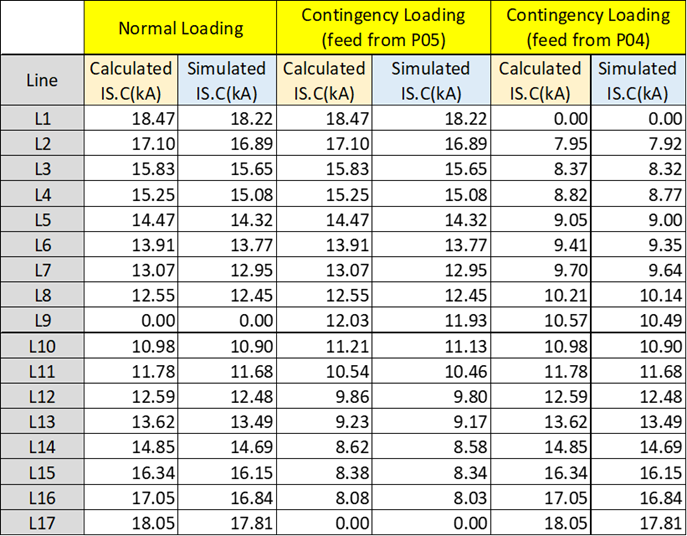

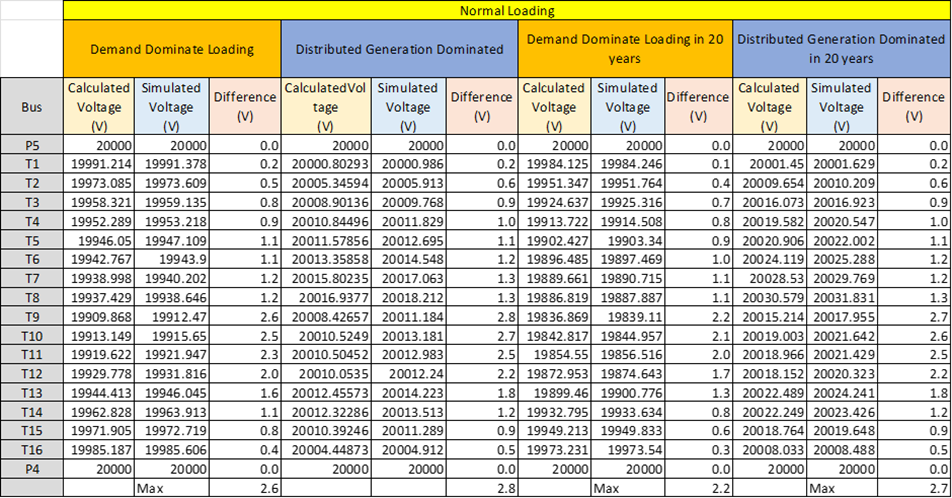